In [1]:
# Core
import time
import random
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt

# NLP
import gensim
import nltk
import spacy
from pymystem3 import Mystem
from string import punctuation
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

In [129]:
train = pd.read_csv("../data/propaganda_detection_our_data/fake_detection_df_train.csv")
test = pd.read_csv("../data/propaganda_detection_our_data/fake_detection_df_test.csv")
val = pd.read_csv("../data/propaganda_detection_our_data/fake_detection_df_val.csv")

In [130]:
train.head()

,id,text,label
0,00000_03514,Чернигов прилет во многоэтажку. Говорят русска...,True
1,00002_06059,Председатель Следственного комитета РФ Алексан...,True
2,00003_08645,Все сейчас массово хотят уехать со Львова.,True
3,00004_00901,«К военным подошли бабушки и попросили убрать ...,True
4,00006_06251,"С уважение отношусь к Лобаеву, но Владислав, е...",True


In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      880 non-null    object
 1   text    880 non-null    object
 2   label   880 non-null    bool  
dtypes: bool(1), object(2)
memory usage: 14.7+ KB


In [132]:
print("Train Target distribution")
print(train.label.value_counts(normalize=True), '\n')

print("Test Target distribution")
print(test.label.value_counts(normalize=True), '\n')

print("Validation Target distribution")
print(val.label.value_counts(normalize=True), '\n')

Train Target distribution
True     0.618182
False    0.381818
Name: label, dtype: float64 

Test Target distribution
True     0.560484
False    0.439516
Name: label, dtype: float64 

Validation Target distribution
True     0.622047
False    0.377953
Name: label, dtype: float64 



In [133]:
# For simplier preprocessing
data = pd.concat([train, val]).reset_index(drop=True)

In [134]:
stop_words = stopwords.words('russian')

# Improving stopwords
ukrainian_stop_words = ["авжеж","адже","але",
                        "б","без","був","була",
                        "були","було","бути",
                        "більш","вам","вас",
                        "весь","вздовж","ви",
                        "вниз","внизу","вона",
                        "вони","воно","все",
                        "всередині","всіх",
                        "від","він","да",
                        "давай","давати","де"
                        ,"дещо","для","до",
                        "з","завжди","замість",
                        "й","коли","ледве",
                        "майже","ми","навколо",
                        "навіть","нам","от",
                        "отже","отож","поза",
                        "про","під","та","так",
                        "такий","також","те",
                        "ти","тобто","тож",
                        "тощо","хоча","це",
                        "цей","чи","чого",
                        "що","як","який",
                        "якої","є","із",
                        "інших","їх","її"]

#stop_words.extend(ukrainian_stop_words)
stop_words.extend(['это' ,'from', 'subject', 're', 'edu', 'use', 'https', 'link', 'href', 'onclick', '://', 't', 'me'])

In [135]:
mystem = Mystem()
def preprocess(text, stemming=True):
    if stemming:
        tokens = mystem.lemmatize(text.lower())
        tokens = [token for token in tokens if token not in stop_words\
                  and token != " "\
                  and token.strip() not in punctuation]
    else:
        tokens = gensim.utils.simple_preprocess(text)
        tokens = [token for token in tokens if (token not in\
                    gensim.parsing.preprocessing.STOPWORDS and 
                    token not in stop_words)]
        
    text = " ".join(tokens)
    return text

In [136]:
# Take a look at preprocessed text
for i in range(3):
    word = train.loc[random.randrange(train.shape[0])]['text']
    print(word, '\n')
    print(preprocess(word), '\n')

Пишут из Мариуполя: Арта работает где-то из Сартаны (примерно). По городу скорые забегали в сторону Восточного. По ходу там потери. 

писать мариуполь арт работать где-то сартана примерно город скорый забегать сторона восточный ход потеря 

Фейк: Устройства Apple могут быть заблокированы при автообновлении из-за возможных санкций. Владельцам гаджетов рекомендуют отключить автоматическое обновление операционных систем. Такие сообщения активно репостят в мессенджерах. Правда: Компания Apple не делала официальных заявлений относительно блокировки или ограничений в работе своих устройств на территории России. Подобные сообщения выгодны мошенникам: отключение автообновлений позволяет злоумышленникам выявить уязвимости и получить незаконный доступ к личным данным пользователей. 

фейк устройство apple мочь заблокировать автообновление из-за возможный санкция владелец гаджет рекомендовать отключать автоматический обновление операционный система сообщение активно репощать мессенджер правда ком

In [137]:
data['text'] = data['text'].apply(preprocess, False)
test['text'] = test['text'].apply(preprocess, False)

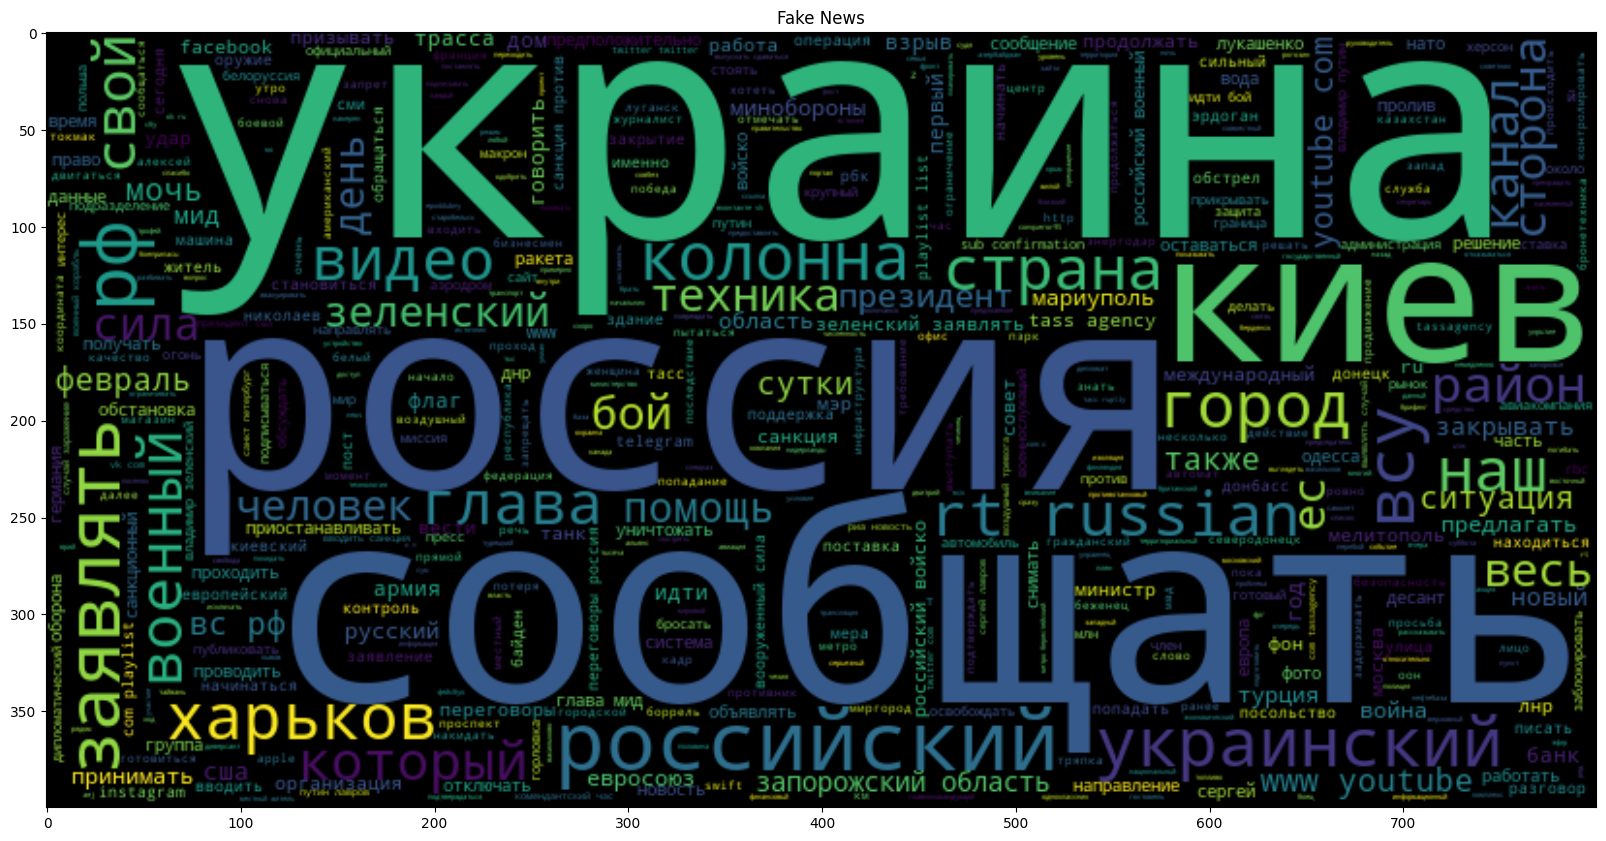

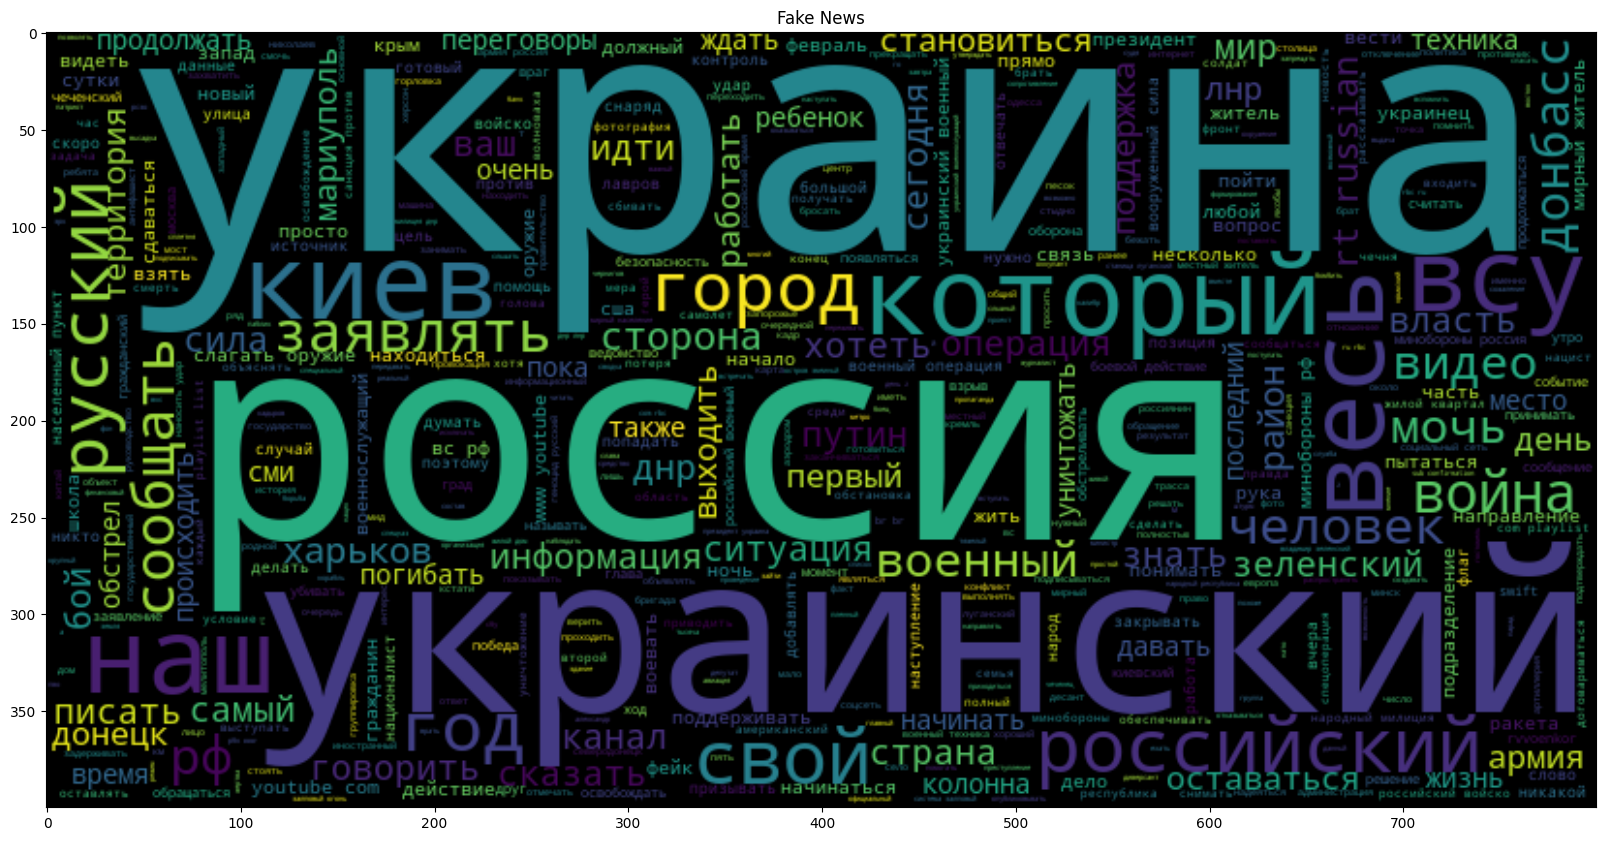

In [138]:
# Plot wordcloud representation

for i in range(2):
    plt.figure(figsize = (20,20)) 
    plt.title("Fake News")
    wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(data.loc[data.label == i, "text"]))
    plt.imshow(wc, interpolation = 'bilinear')

In [139]:
spacy_nlp = spacy.load('ru_core_news_md')

In [140]:
#vectorizer = CountVectorizer()
vectorizer = CountVectorizer(ngram_range=(1,2))
#vectorizer = TfidfVectorizer()
#vectorizer = CountVectorizer(token_pattern = None, tokenizer=Tokenizer(spacy_nlp.vocab))

model = Pipeline([
        ("vectorizer", vectorizer),
        ("logistic_regression", LogisticRegression())
    ])

In [141]:
X = data['text']
y = data['label']

X_test = test['text']
y_test = test['label']

In [155]:
# Number of folds in cross validation
FOLDS = 10
preds = np.zeros(len(X_test))
valid_scores = {'ROC AUC': [], 'Precision': [], 'Recall': [], 'Time' : []}
cross_validation = StratifiedKFold(n_splits=FOLDS, random_state=69, shuffle=True)

start = time.time()
for fold, (train_idx, val_idx) in enumerate(cross_validation.split(X, y)):
    # Get training and validation sets
    X_train, X_valid = X[train_idx], X[val_idx]
    y_train, y_valid = y[train_idx], y[val_idx]

    # Train model
    model.fit(X_train, y_train)

    # Make predictions and measure ROC AUC
    preds += model.predict(X_test)
    prediction = model.predict(X_valid)
    valid_scores['ROC AUC'] = roc_auc_score(y_valid, prediction)
    valid_scores['Precision'] = precision_score(y_valid, prediction)
    valid_scores['Recall'] = recall_score(y_valid, prediction)
stop = time.time()

valid_scores['Time'] = np.round((stop - start) / 60, 2)
print('Training time (mins):', np.round((stop - start) / 60, 2))
preds = preds / (FOLDS)

Training time (mins): 0.04


In [156]:
# Show results
valid_scores

{'ROC AUC': 0.6999151103565365,
 'Precision': 0.7796610169491526,
 'Recall': 0.7419354838709677,
 'Time': 0.04}

In [157]:
roc_auc_score(y_test, preds)

0.7357930169625766

## Logistic regression

1. Spacy tokenizer + improved stopwords:
(StratifiedKFold, 10 folds)

**Valid**

- **ROC AUC score** : 0.5526315789473684
- **Precision** : 0.6458333333333334
- **Recall** : 1.0
- **Time** : 0.01

**Test** 0.5

2. TfidfVectorizer + improved stopwords:
(StratifiedKFold, 10 folds)

**Valid**

- **ROC AUC score** : 0.5526315789473684
- **Precision** : 0.6458333333333334
- **Recall** : 1.0
- **Time** : 0.01

0.6060656062306119

3. CountVectorizer + improved stopwords
(StratifiedKFold, 10 folds)

**Valid**

- **ROC AUC score** : 0.7058573853989812
- **Precision** : 0.7692307692307693
- **Recall** : 0.8064516129032258
- **Time** : 0.01

**Test** 0.7291927925549468

4. CountVectorizer(n_grams=(1,2)) + improved stopwords
(StratifiedKFold, 10 folds)

**Valid**

- **ROC AUC score** : 0.7058573853989812
- **Precision** : 0.7692307692307693
- **Recall** : 0.8064516129032258
- **Time** : 0.01

**Test** 0.729654808263481

## Best result:
5. CountVectorizer(n_grams=(1,2))
(StratifiedKFold, 10 folds)

**Valid**

- **ROC AUC score** : 0.7058573853989812
- **Precision** : 0.7692307692307693
- **Recall** : 0.8064516129032258
- **Time** : 0.01

**Test** 0.7357930169625766